In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import mode


# pipelines
from sklearn.pipeline import Pipeline



# Customer Data

In this assignment we are going to examine some customer data gathering from my very famous internet company "the best one ever".  "The best one ever" is the best company ever that sells important things online.  In this investigation we want to find if there are any natural groups of customers in my dataset.  The first step is to just get the data in a format we can feed to our machine learning models. 

In [3]:
data = pd.read_csv('best_one_ever_database.csv', index_col='id')

In [4]:
data.head()

,first_name,last_name,email,gender,ip_address,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent
id,,,,,,,,,,
1,Jarred,Hallsworth,jhallsworth0@biblegateway.com,Non-Binary,223.109.240.148,$606.16,85349,7,NaN,3310.505486
2,Wayne,Robez,wrobez1@t.co,Male,73.174.113.87,$147.22,85336,9,NaN,2188.852818
3,Casper,Hayles,chayles2@cdc.gov,Male,223.249.117.173,$801.97,85350,4,0.597445,2640.499644
4,Mandie,Szepe,mszepe3@lulu.com,Female,31.143.95.228,$336.77,85364,4,NaN,2872.580992
5,Noam,Cecely,ncecely4@elegantthemes.com,Male,63.71.174.230,$757.45,85369,8,0.127835,2728.008966


In [5]:
data.info() #There are some values null in a couple of rows
            #Object means non numerical objects, we need to change to numbers what we want to use

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   first_name                 2000 non-null   object 
 1   last_name                  2000 non-null   object 
 2   email                      2000 non-null   object 
 3   gender                     2000 non-null   object 
 4   ip_address                 2000 non-null   object 
 5   sales                      2000 non-null   object 
 6   zip_code                   2000 non-null   int64  
 7   total_num_of_transactions  2000 non-null   int64  
 8   prob_of_rebuy              1538 non-null   float64
 9   money_spent                1690 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 171.9+ KB


In [6]:
data['sales']       #It has the dollar symbol we need to transform it

id
1       $606.16 
2       $147.22 
3       $801.97 
4       $336.77 
5       $757.45 
          ...   
1996    $452.62 
1997    $485.46 
1998    $658.12 
1999    $716.78 
2000    $361.77 
Name: sales, Length: 2000, dtype: object

# Cleaning The Data

Taking a look at the data you have to ask yourself the questions

1. 'Which columns are useful for me to keep?'
2. 'Are all the columns usable as features?

Then you may have to do some "work" to get the column to be usable. Let's look at one column together. The first column is titled "first_name" and it seems to be the first name of each customer. Is this a usable feature? Well... not exactly in string format. So I guess I could one hot encode them into binary vectors, but even then... do I want to cluster the customers based on their first name? You can imagine some situation where clustering by name might be relevant (for example trying to guess what generation someone belonged to?) but in this case it seems like it's more of a unique identifier so it may be best to simply remove it. If every value in a column is unique (there are no duplications of the value) then we shouldn't use it as a feature because it will have a 1-1 mapping with the target variable which is not something we ever want. We want our model to learn and generalize from the features, not memorize that the name "jane" bought 5 cans of soda.

Ok, that's the first column, we vote drop! Now you have to go through each and every column and ask yourself "do I keep it? if yes, what extra work might I have to do?" 

Let's walk through it
  
  1. first_name:  this is a unique identifier so we should remove it.
  2. last_name: see above
  3. email: this is unique to an extent.  BUT if we strip the name@ portion of the email and simply keep the domain name, it could possibly aid us. Perhaps certain kinds of customers use certain email services! Worth looking into
  4. Gender: this is certainly relevant, but it's categorical data. We will need to one-hot-encode it.
  5. ip_address: We can perhaps segment the ip's into fields and use them, there maybe overlaps or correlations among different fields. Or maybe you know more about IP addresses than I do and this is totally useless
  6. sales: we certainly need this column, but we need to convert it a floating point type: remove the '$' and convert the dtype of the column
  7. zip_code: I think we can just leave this as is.
  8. prob-of_rebuy: I think we can just leave this as is.
  9. Money_spent: seems fine to me!
  

In [7]:
# drop the name columns using pandas.drop()
X = data.drop(labels=['first_name','last_name'],axis=1) # drop the first and last name, will not have any impact on the model for predictions

In [8]:
data.info() # In the data the first and last names are still there

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   first_name                 2000 non-null   object 
 1   last_name                  2000 non-null   object 
 2   email                      2000 non-null   object 
 3   gender                     2000 non-null   object 
 4   ip_address                 2000 non-null   object 
 5   sales                      2000 non-null   object 
 6   zip_code                   2000 non-null   int64  
 7   total_num_of_transactions  2000 non-null   int64  
 8   prob_of_rebuy              1538 non-null   float64
 9   money_spent                1690 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 171.9+ KB


In [9]:
X.info()        #In X the first and last names were deleted

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   email                      2000 non-null   object 
 1   gender                     2000 non-null   object 
 2   ip_address                 2000 non-null   object 
 3   sales                      2000 non-null   object 
 4   zip_code                   2000 non-null   int64  
 5   total_num_of_transactions  2000 non-null   int64  
 6   prob_of_rebuy              1538 non-null   float64
 7   money_spent                1690 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 140.6+ KB


### Transform string columns into useful features

1. email column
2. sales column (remove $ sign)

We will use the pandas `apply` function take a function that operates on a string and apply it to the entire column. I will do the first one, and you will do the next one.

In [10]:
def strip_dollar(x):
    return x[1:]

In [11]:
strip_dollar("$345")        #check if it is working well

'345'

In [12]:
type(strip_dollar)

function

In [13]:
# apply the function to the column and assign it back to the column (it does not work inplace)
X['sales']=X['sales'].apply(strip_dollar)

In [14]:
X['sales']      #It is still a object type we need to changeto astype

id
1       606.16 
2       147.22 
3       801.97 
4       336.77 
5       757.45 
         ...   
1996    452.62 
1997    485.46 
1998    658.12 
1999    716.78 
2000    361.77 
Name: sales, Length: 2000, dtype: object

In [15]:
# cast the column to a floating point type - this is very important, otherwise it will be
# an object type column that we cannot do arithmetic on the column

X['sales']=X['sales'].astype('float32')

In [16]:
X['sales'].mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of id
1       606.159973
2       147.220001
3       801.969971
4       336.769989
5       757.450012
           ...    
1996    452.619995
1997    485.459991
1998    658.119995
1999    716.780029
2000    361.769989
Name: sales, Length: 2000, dtype: float32>

In [17]:
X.head()

,email,gender,ip_address,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent
id,,,,,,,,
1,jhallsworth0@biblegateway.com,Non-Binary,223.109.240.148,606.159973,85349,7,NaN,3310.505486
2,wrobez1@t.co,Male,73.174.113.87,147.220001,85336,9,NaN,2188.852818
3,chayles2@cdc.gov,Male,223.249.117.173,801.969971,85350,4,0.597445,2640.499644
4,mszepe3@lulu.com,Female,31.143.95.228,336.769989,85364,4,NaN,2872.580992
5,ncecely4@elegantthemes.com,Male,63.71.174.230,757.450012,85369,8,0.127835,2728.008966


Now you need to
1. write a function to strip the name portion of the email
2. Apply it to the column


In [18]:
# define functions to apply to the dataframe
def strip_emails(x):
    at=x.find('@')
    return x[at+1:]
    # your code here

test_email = 'thisismymail@gmail.com'
print(strip_emails(test_email))

gmail.com


In [19]:
# apply the function to the column and assign it back to the column (it does not work inplace)
X['email']=X['email'].apply(strip_emails)
X.head()

,email,gender,ip_address,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent
id,,,,,,,,
1,biblegateway.com,Non-Binary,223.109.240.148,606.159973,85349,7,NaN,3310.505486
2,t.co,Male,73.174.113.87,147.220001,85336,9,NaN,2188.852818
3,cdc.gov,Male,223.249.117.173,801.969971,85350,4,0.597445,2640.499644
4,lulu.com,Female,31.143.95.228,336.769989,85364,4,NaN,2872.580992
5,elegantthemes.com,Male,63.71.174.230,757.450012,85369,8,0.127835,2728.008966


# Is the email column going to be worth it?
Let's take a look at this email column and decide if it could help us or not.


In [20]:
# how many unique domains are there?
counts=X['email'].value_counts()
counts

email
tiny.cc                10
xrea.com               10
furl.net               10
qq.com                 10
cbsnews.com            10
                       ..
fda.gov                 1
ed.gov                  1
devhub.com              1
creativecommons.org     1
ox.ac.uk                1
Name: count, Length: 490, dtype: int64

In [21]:
X['email'].unique().shape

(490,)

In [22]:
counts.values

array([10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4

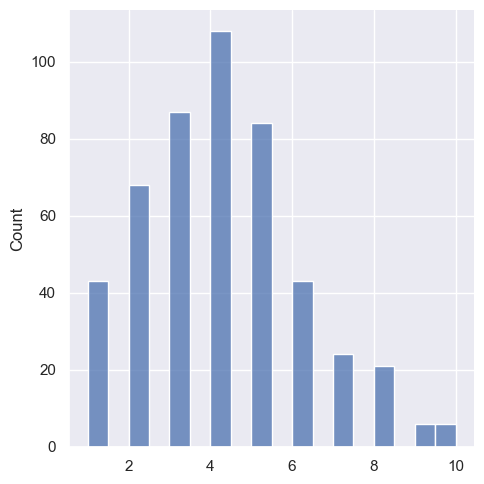

In [23]:
sns.displot(counts.values)

In [24]:
print(X['email'].copy)

<bound method NDFrame.copy of id
1        biblegateway.com
2                    t.co
3                 cdc.gov
4                lulu.com
5       elegantthemes.com
              ...        
1996       opensource.org
1997            yahoo.com
1998           usnews.com
1999           toplist.cz
2000        woothemes.com
Name: email, Length: 2000, dtype: object>


In [25]:
#We make sure to copy it over and save it for later
emails=X['email'].copy()
X.drop('email',axis=1,inplace=True)

Based on what you think, you can either keep the column or not. It never hurts to try using it and then drop it later, it's also not a big deal if you are sure it's going to be useless. You will learn to have intuition with these things over time.

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     2000 non-null   object 
 1   ip_address                 2000 non-null   object 
 2   sales                      2000 non-null   float32
 3   zip_code                   2000 non-null   int64  
 4   total_num_of_transactions  2000 non-null   int64  
 5   prob_of_rebuy              1538 non-null   float64
 6   money_spent                1690 non-null   float64
dtypes: float32(1), float64(2), int64(2), object(2)
memory usage: 117.2+ KB


## Splitting the IP Address
We now need to split up the IP address, we will use Pandas's built in str method for this.
Again, I'm not even sure this is a good idea, but it's certainly fine practice to learn how to spit up strings in pandas!

In [27]:
X.head()

,gender,ip_address,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent
id,,,,,,,
1,Non-Binary,223.109.240.148,606.159973,85349,7,NaN,3310.505486
2,Male,73.174.113.87,147.220001,85336,9,NaN,2188.852818
3,Male,223.249.117.173,801.969971,85350,4,0.597445,2640.499644
4,Female,31.143.95.228,336.769989,85364,4,NaN,2872.580992
5,Male,63.71.174.230,757.450012,85369,8,0.127835,2728.008966


In [28]:
# We are going to use pandas str method here

X[['first_ip','second_ip','third_ip','fourth_ip']] = X['ip_address'].str.split(pat=".",expand=True)

In [29]:
a=X['ip_address'].str.split(".",expand=True)

In [30]:
a

,0,1,2,3
id,,,,
1,223,109,240,148
2,73,174,113,87
3,223,249,117,173
4,31,143,95,228
5,63,71,174,230
...,...,...,...,...
1996,99,212,77,78
1997,43,253,114,105
1998,70,249,185,148


In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     2000 non-null   object 
 1   ip_address                 2000 non-null   object 
 2   sales                      2000 non-null   float32
 3   zip_code                   2000 non-null   int64  
 4   total_num_of_transactions  2000 non-null   int64  
 5   prob_of_rebuy              1538 non-null   float64
 6   money_spent                1690 non-null   float64
 7   first_ip                   2000 non-null   object 
 8   second_ip                  2000 non-null   object 
 9   third_ip                   2000 non-null   object 
 10  fourth_ip                  2000 non-null   object 
dtypes: float32(1), float64(2), int64(2), object(6)
memory usage: 179.7+ KB


In [32]:
# now we cast the columns as floats, because we always need numbers for our models!
X[['first_ip','second_ip','third_ip','fourth_ip']] = X[['first_ip','second_ip','third_ip','fourth_ip']].astype('float32')
# we also drop the original column
X.drop('ip_address', axis=1, inplace=True)

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     2000 non-null   object 
 1   sales                      2000 non-null   float32
 2   zip_code                   2000 non-null   int64  
 3   total_num_of_transactions  2000 non-null   int64  
 4   prob_of_rebuy              1538 non-null   float64
 5   money_spent                1690 non-null   float64
 6   first_ip                   2000 non-null   float32
 7   second_ip                  2000 non-null   float32
 8   third_ip                   2000 non-null   float32
 9   fourth_ip                  2000 non-null   float32
dtypes: float32(5), float64(2), int64(2), object(1)
memory usage: 132.8+ KB


# One Hot Encoding

Ok we are almost done, we just have to convert the gender column into something integer that we can use. We will use one-hot-encoding since gender is a categorical variable.

Pandas has a `get_dummies()` function that will be very useful.
I'm going to let you look it up and learn how to use it.


In [34]:
# check the gender distribution, just because
X.gender.value_counts()

gender
Male          775
Female        725
Non-Binary    500
Name: count, dtype: int64

In [35]:
dumbdumbs=pd.get_dummies(X['gender'], dtype=int)       #In the video he gets  or 1 values, I get True or False, (need to add int)
dumbdumbs

,Female,Male,Non-Binary
id,,,
1,0,0,1
2,0,1,0
3,0,1,0
4,1,0,0
5,0,1,0
...,...,...,...
1996,1,0,0
1997,1,0,0
1998,0,1,0


In [36]:
X=pd.concat((X,dumbdumbs),axis=1)

In [37]:
X.drop(['gender'],axis=1, inplace=True)

In [38]:
X.head()

,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent,first_ip,second_ip,third_ip,fourth_ip,Female,Male,Non-Binary
id,,,,,,,,,,,,
1,606.159973,85349,7,NaN,3310.505486,223.0,109.0,240.0,148.0,0,0,1
2,147.220001,85336,9,NaN,2188.852818,73.0,174.0,113.0,87.0,0,1,0
3,801.969971,85350,4,0.597445,2640.499644,223.0,249.0,117.0,173.0,0,1,0
4,336.769989,85364,4,NaN,2872.580992,31.0,143.0,95.0,228.0,1,0,0
5,757.450012,85369,8,0.127835,2728.008966,63.0,71.0,174.0,230.0,0,1,0


In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sales                      2000 non-null   float32
 1   zip_code                   2000 non-null   int64  
 2   total_num_of_transactions  2000 non-null   int64  
 3   prob_of_rebuy              1538 non-null   float64
 4   money_spent                1690 non-null   float64
 5   first_ip                   2000 non-null   float32
 6   second_ip                  2000 non-null   float32
 7   third_ip                   2000 non-null   float32
 8   fourth_ip                  2000 non-null   float32
 9   Female                     2000 non-null   int32  
 10  Male                       2000 non-null   int32  
 11  Non-Binary                 2000 non-null   int32  
dtypes: float32(5), float64(2), int32(3), int64(2)
memory usage: 140.6 KB


# Data Preprocessing Stage 2

Ok, we are done with stage 1 - we have converted everything into numeric features and dropped all the unneccessary things. Please double check that! Make sure all features are numeric (a check with .info() should do the trick).

However we do have missing values. Which two columns have missing values?
How many values are missing?
What should we do about those missing values?

You can either impute (fill in) the missing values, or drop the rows which contain them. The choice is up to you!
Either way, you should practice both methods. This way you can practice coding both solutions.

Note:
The `DataFrame.fillna()` method essentially assumes that you are using timeseries data. We are not, so I wouldn't use this. In order to impute simple values, you can use numpy easily, but... I'm lazy and would probably use the scikit-learn implementation.

https://scikit-learn.org/stable/modules/impute.html

In [40]:
X['prob_of_rebuy'].mean()   #We will use this mean value to fill in the empty values

0.510103834453186

In [41]:
X.head()

,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent,first_ip,second_ip,third_ip,fourth_ip,Female,Male,Non-Binary
id,,,,,,,,,,,,
1,606.159973,85349,7,NaN,3310.505486,223.0,109.0,240.0,148.0,0,0,1
2,147.220001,85336,9,NaN,2188.852818,73.0,174.0,113.0,87.0,0,1,0
3,801.969971,85350,4,0.597445,2640.499644,223.0,249.0,117.0,173.0,0,1,0
4,336.769989,85364,4,NaN,2872.580992,31.0,143.0,95.0,228.0,1,0,0
5,757.450012,85369,8,0.127835,2728.008966,63.0,71.0,174.0,230.0,0,1,0


In [42]:
#Still we have missing values

In [43]:
from sklearn.impute import SimpleImputer
imp=SimpleImputer(missing_values=np.nan, strategy='mean')

In [44]:
X_=imp.fit_transform(X)

In [45]:
X=pd.DataFrame(X_, columns=X.columns)

In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sales                      2000 non-null   float64
 1   zip_code                   2000 non-null   float64
 2   total_num_of_transactions  2000 non-null   float64
 3   prob_of_rebuy              2000 non-null   float64
 4   money_spent                2000 non-null   float64
 5   first_ip                   2000 non-null   float64
 6   second_ip                  2000 non-null   float64
 7   third_ip                   2000 non-null   float64
 8   fourth_ip                  2000 non-null   float64
 9   Female                     2000 non-null   float64
 10  Male                       2000 non-null   float64
 11  Non-Binary                 2000 non-null   float64
dtypes: float64(12)
memory usage: 187.6 KB
